# Deep Equilibrium Nets

The aim is to use TensorFlow (v2.6.0) to solve a simple model 3-generation model with deep equilibrium nets.

# Set up

In [79]:
# Setting up
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras import Sequential
from tensorflow.keras.initializers import HeNormal, HeUniform, GlorotNormal, GlorotUniform
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

2.9.1


In [80]:
# Further setting up

# Set the seed for replicable results
seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

# Helper variable
lb = 1e-3 # Define lower bound for c, h
eps = 1e-5 # Define inverse punishment value for negative predictions

### Model calibration

In [81]:
# DEFINE SCALAR PARAMETERS
alpha = 0.1
beta = 0.99**25
gamma = 3
J = 3
jret = 2
thetaret = 0.2
delta = (1 + 0.015)**25 - 1
Gmu = (1 + 0.005)**25
Gchi = (1 + 0.02)**25
Pic = (1 + 0.02)**25
Hs = 0.79/5

# COMPUTE PARAMETER TRANSFORMATIONS
betahat = Gchi**((1-alpha)*(1-gamma))*beta
Pih = Gchi * Pic

# DEFINE AGE-VARYING PRODUCTIVITY AND SURVIVAL RATES
chi1 = 0.874264
mu1 = 0.493497

chi = chi1 * np.array([1, 1.5])

zeta = np.array([0.976163, 0.784336, 0])
zeta_0 = np.concatenate(([1], zeta[0:2]))

# COMPUTE POPULATION DISTRIBUTION
mu = np.zeros(J)
mu[0] = mu1
for j in range(1, J):
    mu[j] = (zeta[j-1] / Gmu) * mu[j-1]

# COMPUTE TAX RATE
tau = np.sum([thetaret*Gchi**(jret - j)*mu[j] for j in range(jret, J)]) / np.sum(mu[0:jret]*chi)

# COMPUTE AGE-VARYING INCOME
y = np.zeros(J)
for j in range(J):
    if j < jret:
        y[j] = (1-tau) * chi[j]
    else:
        y[j] = thetaret * Gchi ** (jret-j)

In [82]:
num_episodes = 10000
len_episodes = 64
epochs_per_episode = 4
minibatch_size = 32
num_minibatches = int(len_episodes / minibatch_size)
lr = 1e-5

# Neural network architecture parameters
num_input_nodes = 2 + 3*J  # Dimension of extended state space (4 aggregate quantities and 3 distributions)
num_hidden_nodes = [100, 50]  # Dimension of hidden layers
num_output_nodes = J + J-1 + 2  # Output dimension: 3 for housing, 2 for assets, 2 aggregate quantities

# 2. Neural network

In [83]:
# Define neural network
model = Sequential([
    Dense(256, activation='swish', input_shape=(num_input_nodes,), kernel_initializer=HeNormal),
    Dense(128, activation='swish'),
    Dense(num_output_nodes)
])

In [84]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 256)               3072      
                                                                 
 dense_10 (Dense)            (None, 256)               65792     
                                                                 
 dense_11 (Dense)            (None, 7)                 1799      
                                                                 
Total params: 70,663
Trainable params: 70,663
Non-trainable params: 0
_________________________________________________________________


# 3. Economic Model

### 3.A. Current period (t) <a id='currentperiod'></a>

Using the current extended state $\bm{X}$, we can calculate the economy. The state is composed of today's tangible wealth. Note that this constitutes the minimal state. Often, including redundant variables is a simple way to increase the speed of convergence (see the [working paper](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3393482) for more information on this).

Using the current extended state $\bm{X}$, we predict how much the agents save in financial assets and how much housing they consume. We also predict house prices and interest rates. We do this by passing the state $\bm{X}$ to the neural network.

Then we can calculate the agents' consumptions.

In [85]:
# Generate a random economically feasible starting point
# X = tf.random.uniform(shape=(8, num_input_nodes), minval=0, maxval=1)

In [86]:
# @tf.function
def unpack_output(output):
    """
    Unpacks the output of the neural network

    Parameters
    ----------
    output : tensor
        Output of neural network
    """

    # Unpack simulated housing and financial assets
    R_orig = tf.expand_dims(output[:, 0], axis=1)
    ph_orig = tf.expand_dims(output[:, 1], axis=1)
    a_out = output[:, 2:4]
    h_out_orig = output[:, 4:7]

    return R_orig, ph_orig, a_out, h_out_orig

In [87]:
# unpack_output(model(X))

In [88]:
# @tf.function
def compute_economy(X, output):
    """
    Solves today's economy given state and output of neural network

    Parameters
    ----------
    output : _type_
        _description_
    """

    # Unpack inputs and outputs
    # R_state = tf.cast(tf.expand_dims(X[:, 2], 1), dtype=tf.float32)
    # ph_state = tf.cast(tf.expand_dims(X[:, 3], 1), dtype=tf.float32)
    w = tf.cast(X[:, 2:5], dtype=tf.float32) # Distribution of tangible wealth
    R_orig, ph_orig, a_out, h_out_orig = unpack_output(output)

    # The network can predict negative values before it learns not to. 
    R = tf.maximum(R_orig, tf.ones_like(R_orig)*eps)
    ph = tf.maximum(ph_orig, tf.ones_like(ph_orig)*eps)
    h_out = tf.maximum(h_out_orig, tf.ones_like(h_out_orig)*lb)

    # Compute savings for oldest cohort
    a_out_J = -(Pih * ph * tf.expand_dims(h_out[:, J-1], 1)) / R
    a_out_all = tf.concat([a_out, a_out_J], axis=1)

    # Compute consumption and impose non-negative constraint
    c_orig = w - ph*(1+delta)*h_out - a_out_all
    c = tf.maximum(c_orig, tf.ones_like(c_orig)*lb)

    # Compute aggregate savings and housing
    A_out = tf.reduce_sum(mu * a_out_all, axis=1, keepdims=True)
    H_out = tf.reduce_sum(mu * h_out, axis=1, keepdims=True)

    return R_orig, R, ph_orig, ph, a_out, a_out_all, h_out_orig, h_out, c_orig, c, A_out, H_out

In [89]:
# compute_economy(X, model(X))

In [90]:
# @tf.function
def compute_next_state(X, output):
    """
    Computes the state for the next period, given the outputs of the neural network today.

    Parameters
    ----------
    outputs : tensors
        Outputs of neural network
    """

    _, R, _, ph, a_out, _, _, h_out, _, _, _, _ = compute_economy(X, output)

    m = tf.shape(X)[0]

    a_prime = tf.concat([tf.zeros([m, 1]), a_out], axis=1)
    h_prime = tf.concat([tf.zeros([m, 1]), h_out[:, 0:J-1]], axis=1)

    # Distribution of tomorrow's financial wealth
    w_prime = y + (R*a_prime + Pih*ph*h_prime) / (zeta_0*Gchi*Pic)

    # Tomorrow's extended state: Concatenate the parts together
    X_prime = tf.concat([
        # A_out,
        # H_out,
        R,
        ph,
        w_prime,
        a_prime,
        h_prime
        ], axis=1)        

    return X_prime

In [91]:
# compute_next_state(X, model(X))

In [92]:
# @tf.function
def run_period(X):
    """
    Evaluate neural network given today's state and generate tomorrow's state.

    Parameters
    ----------
    X : tensor
        Today's extended state

    Returns
    -------
    tensor
        Tomorrow's extended state
    """

    # Evaluate neural network
    output = model(X)

    # Compute next state
    X_prime = compute_next_state(X, output)
    
    return X_prime

In [93]:
# run_period(X)

In [94]:
# @tf.function
def euler_errors(X, output, X_prime, output_prime):
    """
    Compute error functions

    Parameters
    ----------
    X : _type_
        _description_
    output : _type_
        _description_
    X_prime : _type_
        _description_
    output_prime : _type_
        _description_

    Returns
    -------
    _type_
        _description_
    """
    # Compute today's economy
    R_orig, R, ph_orig, ph, _, _, h_out_orig, h_out, c_orig, c, A_out, H_out = compute_economy(X, output)

    # Compute tomorrow's economy
    R_prime_orig, R_prime, ph_prime_orig, ph_prime, _, _, h_prime_out_orig, h_prime_out, c_prime_orig, c_prime, A_prime_out, H_prime_out = compute_economy(X_prime, output_prime)

    # Euler equation 1 (Intertemporal)
    opt_euler1 = -1 + (c_prime[:, 1:J] / c[:, 0:J-1])*(R*betahat/(Gchi*Pic))**(-1/gamma)
    # opt_euler1 = grad_Uc(c[:, 0:J-1], h_out[:, 0:J-1]) - grad_Uc(c_prime[:, 1:J], h_prime_out[:, 1:J]) * R*betahat/(Gchi*Pic)

    # Euler equation 2 (Intratemporal)
    opt_euler2 = -1 + (c/h_out)*(((1-alpha)/alpha)*ph*(1+delta-Pih/R))**(-1)
    # opt_euler_intra = -1 + (c/h_out)*(((1-alpha)/alpha)*ph*(1+delta-Pih/R))**(-1)
    # opt_euler_intra_prime = -1 + (c_prime/h_prime_out)*(((1-alpha)/alpha)*ph_prime*(1+delta-Pih/R_prime))**(-1)
    # opt_euler2 = tf.concat([opt_euler_intra, opt_euler_intra_prime], axis=1)

    # Punishment for negative consumption
    orig_cons = tf.concat([c_orig, c_prime_orig], axis=1)
    opt_punish_cons = (1./eps) * tf.maximum(-1 * orig_cons, tf.zeros_like(orig_cons))

    # Punishment for negative housing
    orig_housing = tf.concat([h_out_orig, h_prime_out_orig], axis=1)
    opt_punish_housing = (1./eps) * tf.maximum(-1 * orig_housing, tf.zeros_like(orig_housing))

    # Punishment for negative interest rate
    orig_R = tf.concat([R_orig, R_prime_orig], axis=1)
    opt_punish_R = (1./eps) * tf.maximum(-1 * orig_R, tf.zeros_like(orig_R))

    # Punishment for negative house price
    orig_ph = tf.concat([ph_orig, ph_prime_orig], axis=1)
    opt_punish_ph = (1./eps) * tf.maximum(-1 * orig_ph, tf.zeros_like(orig_ph))

    # Market clearing condition for aggregate savings
    # opt_market_a = A_out
    # opt_market_a_prime = A_prime_out
    # opt_market_A = tf.concat([opt_market_a, opt_market_a_prime], axis=1)
    opt_market_A = A_out

    # Market clearing condition for aggregate housing
    # opt_market_h = H_out - Hs
    # opt_market_h_prime = H_prime_out - Hs
    # opt_market_H = tf.concat([opt_market_h, opt_market_h_prime], axis=1)
    opt_market_H = H_out - Hs

    # Concatenate the equilibrium functions
    combined_opt = [opt_euler1, opt_euler2, opt_punish_cons, opt_punish_housing, opt_punish_R, opt_punish_ph, opt_market_A, opt_market_H]
    opt_predict = tf.concat(combined_opt, axis=1)

    # Check if Euler errors are valid
    tf.debugging.assert_all_finite(opt_predict, "Euler errors not finite")

    # Define the "correct" outputs. For all equilibrium functions, the correct outputs is zero.
    opt_correct = tf.zeros_like(opt_predict)

    return opt_predict, opt_correct

In [95]:
# output = model(X)
# X_prime = compute_next_state(X, output)
# output_prime = model(X_prime)

# # Compute today's economy
# R_orig, R, ph_orig, ph, _, _, h_out_orig, h_out, c_orig, c, A_out, H_out = compute_economy(X, output)

# # Compute tomorrow's economy
# R_prime_orig, R_prime, ph_prime_orig, ph_prime, _, _, h_prime_out_orig, h_prime_out, c_prime_orig, c_prime, A_prime_out, H_prime_out = compute_economy(X_prime, output_prime)

# opt_euler2 = grad_Uh(c, h_out) - grad_Uc(c, h_out) * ph * (1 + delta - Pih/R)

# print("c:", c)
# print("h:", h_out)
# print("grad_h", grad_Uh(c, h_out))
# print("grad_c", grad_Uc(c, h_out))
# print(opt_euler2)

In [96]:
# @tf.function
def simulate(X):
    """
    Simulate and return euler errors

    Parameters
    ----------
    X : _type_
        _description_

    Returns
    -------
    _type_
        Euler errors
    """

    # Evaluate neural network given today's state
    output = model(X)
    tf.debugging.assert_all_finite(output, "Prediction not finite")

    # Compute state tomorrow
    X_prime = compute_next_state(X, output)

    # Evaluate neural network given tomorrow's state
    output_prime = model(X_prime)

    # Compute euler errors and other equilibrium conditions
    opt_predict, opt_correct = euler_errors(X, output, X_prime, output_prime)

    return opt_predict, opt_correct

In [97]:
# TEST
# simulate(X)

#### Optimizer

Next, we chose an optimizer; i.e., the algorithm we use to perform gradient descent. We use [Adam](https://arxiv.org/abs/1412.6980), a favorite in deep learning research. Adam uses a parameter specific learning rate and momentum, which encourages gradient descent steps that occur in a consistent direction.

# 4. Training

### Training the _deep equilibrium net_

Now we can begin training.

For each episode, we simulate the training dataset, which is then used to train the neural network. The training set is split into batches, which is fed into the neural network. In each epoch, we pass through the entire training set once. The training lasts for epochs_per_episode.

In [98]:
# Generate a random economically feasible starting point
x_start = tf.random.uniform(shape=(1, num_input_nodes), minval=0, maxval=1)

# Adam optimizer
mse = MeanSquaredError()
optimizer = Adam(learning_rate=lr)

model.compile(
    optimizer,
    loss='mse'
)

In [99]:
def simulate_episodes(x_start, episode_length):
    """Simulate an episode for a given starting point using the current
       neural network state.

    Args:
        x_start: Starting state to simulate forward from,
        episode_length: Number of steps to simulate forward,

    Returns:
        X_episodes: Tensor of states [z, k] to train on (training set).
    """
    
    dim_state = np.shape(x_start)[1]

    # Initialise empty array of episodes
    X_episodes = np.zeros([episode_length, dim_state])
    X_episodes[0, :] = x_start
    X_old = x_start

    for t in range(1, episode_length):
        X_new = run_period(X_old)
        
        # Append it to the dataset
        X_episodes[t, :] = X_new
        X_old = X_new

    return X_episodes

In [100]:
# simulate_episodes(x_start, 2)

In [101]:
# Define full training algorithm
# Which alternates between simulating episodes (valid states) and training_step()

@tf.function
def train_step(X_train):

    X_train = tf.data.Dataset.from_tensor_slices(X_train)
    X_train = X_train.shuffle(buffer_size=len_episodes).batch(minibatch_size)
    loss_value = np.inf

    # add loop for epochs here
    for epoch in range(epochs_per_episode):

        # add loop for batches here - maybe manually batch
        for X_batch in X_train:
            
            with tf.GradientTape() as tape:

                # Forward pass of the model to get Euler errors
                opt_predict, opt_correct = simulate(X_batch) # ERROR HERE

                # Compute loss value
                loss_value = mse(opt_correct, opt_predict)               

            # Use gradient tape to retrieve gradients of trainable variables with respect to loss
            grads = tape.gradient(loss_value, model.trainable_weights)
            capped_gvs = [(tf.clip_by_value(grad, -1.0, 1.0)) for grad in grads]
            # Run one step of gradient descent by updating the value of the variables to minimise the loss
            optimizer.apply_gradients(zip(capped_gvs, model.trainable_weights))
            # optimizer.apply_gradients(zip(grads, model.trainable_weights))

            # Log
            # tf.print(f"Epoch {epoch}: log10(Training loss): {float(tf.math.log(loss_value))}")

    return loss_value

In [102]:
# train_step(x_start)

In [103]:
# @tf.function
def training_algorithm(x_start):

    num_episodes = 30000 #try 30000
    loss_list = np.empty(num_episodes)

    # Training Loops
    for episode in range(num_episodes):

        # Simulate episodes
        X_episodes = simulate_episodes(x_start, len_episodes)

        # Train model
        loss_value = train_step(X_episodes)

        # Update starting episode
        x_start = X_episodes[-1, :].reshape([1, -1])

        # Store losses, euler errors
        loss_list[episode] = float(tf.math.log(loss_value))
        
        # Log
        if episode % 25 == 0:
            tf.print(f"Episode {episode}: log10(loss): {float(tf.math.log(loss_value)):.5f}")
            print(x_start)
          
    return x_start, loss_list

In [104]:
x_final, loss_list = training_algorithm(x_start)

Episode 0: log10(loss): 24.61223
[[ 1.73606560e-01  9.99999975e-06  8.22213590e-01  1.19788647e+00
   1.97711140e-01  0.00000000e+00 -5.36270380e-01 -2.78334543e-02
   0.00000000e+00  1.00000005e-03  1.00000005e-03]]
Episode 25: log10(loss): -0.53902
[[ 0.12951583  0.0970324   0.82221359  1.21722543  0.21718797  0.
  -0.53654402  0.10782626  0.          0.10415594  0.08546302]]
Episode 50: log10(loss): -1.00199
[[ 0.18411054  0.15393186  0.82221359  1.21323597  0.2428035   0.
  -0.62119389  0.20189068  0.          0.1486723   0.12838513]]
Episode 75: log10(loss): -1.21015
[[ 0.206911    0.20711616  0.82221359  1.21653676  0.26841688  0.
  -0.68320525  0.2833308   0.          0.17447545  0.15392944]]
Episode 100: log10(loss): -1.29428
[[ 0.21607992  0.25276777  0.82221359  1.2212503   0.28965127  0.
  -0.74035764  0.36543325  0.          0.18852642  0.16212451]]
Episode 125: log10(loss): -1.30877
[[ 0.20447384  0.29173687  0.82221359  1.22781849  0.29519892  0.
  -0.80293536  0.46153542

InvalidArgumentError: Graph execution error:

Prediction not finite : Tensor had NaN values
	 [[{{node VerifyFinite/CheckNumerics}}]]
	 [[ReduceDataset]] [Op:__inference_train_step_5722810]

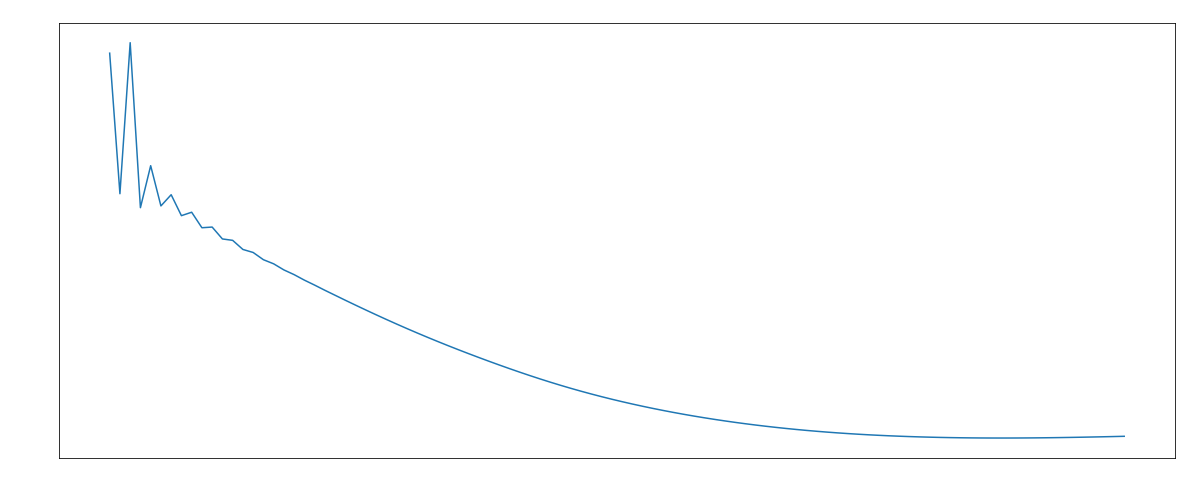

In [ ]:
# Plot loss per episode
plt.figure(figsize=(20, 8))

plt.title(f"log10(loss) by episode with learning rate {lr}", color='white')
plt.plot(loss_list)
plt.xlabel("Episode", color='white')
plt.ylabel("log10(loss)", color='white')
plt.tick_params(axis='x', colors='white')    #setting up X-axis tick color to red
plt.tick_params(axis='y', colors='white') 
plt.show()

In [ ]:
# Save model weights
# model.save_weights('./tmp/model_weights')

In [ ]:
# Load weights
# model.load_weights('./tmp/model_weights')

In [ ]:
# simulate(x_final)

In [ ]:
# print(model(x_final))
# R_orig, R, ph_orig, ph, a_out, a_out_all, h_out_orig, h_out, c_orig, c, A_out, H_out
# compute_economy(x_final, model(x_final))
# compute_next_state(x_final, model(x_final))

In [ ]:
# simulate_episodes(x_final, 10000)                                            

In [ ]:
model(x_start)

<tf.Tensor: shape=(1, 7), dtype=float32, numpy=
array([[-0.12006875,  0.16256215, -0.18262768, -0.01039233, -0.22185068,
         0.02092029, -0.33940065]], dtype=float32)>